In [1]:
import math
import os, sys
import pathlib
from IPython import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
import tensorflow_io as tfio
import tensorflow_hub as hub
from tensorflow.keras import models, Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Input, concatenate, Conv2D, Dense, Dropout, Flatten, MaxPooling2D, BatchNormalization, Activation
from tensorflow.keras.layers.experimental.preprocessing import Resizing, Normalization
physical_devices = tf.config.experimental.list_physical_devices('GPU')
config = tf.config.experimental.set_memory_growth(physical_devices[0], True)
print(f'Running on Python {sys.version}, Tensorflow {tf.__version__}.')

Running on Python 3.8.10 (tags/v3.8.10:3d8993a, May  3 2021, 11:48:03) [MSC v.1928 64 bit (AMD64)], Tensorflow 2.5.0.


In [2]:
# Data loading
seed = 69
AUTOTUNE = tf.data.AUTOTUNE
sample_rate = 16000
tf.random.set_seed(seed)
np.random.seed(seed)

data_dir = pathlib.Path('s1_release')
labels = np.array(tf.io.gfile.listdir(str(data_dir)))
num_labels = len(labels)
print('Commands:', labels)

# load given train set
filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)
print('Number of total examples:', num_samples)
print('Number of examples per label:', len(tf.io.gfile.listdir(str(data_dir/labels[0]))))
print('Example file tensor:', filenames[0])

train_files = filenames[:round(num_samples*0.8)]  # first 80%
val_files = filenames[round(num_samples*0.8):]  # last 20%

print('Training set size', len(train_files))
print('Validation set size', len(val_files))

# load given test set
data_dir = pathlib.Path('s1_test_release')
test_files = tf.io.gfile.glob(str(data_dir) + '/*')  # provided
print('Test set size', len(test_files))

Commands: ['bird' 'eight' 'falcon' 'five' 'four' 'nine' 'one' 'seven' 'six' 'snake'
 'three' 'two' 'zero']
Number of total examples: 3250
Number of examples per label: 250
Example file tensor: tf.Tensor(b's1_release\\snake\\train_snake_0102.wav', shape=(), dtype=string)
Training set size 2600
Validation set size 650
Test set size 649


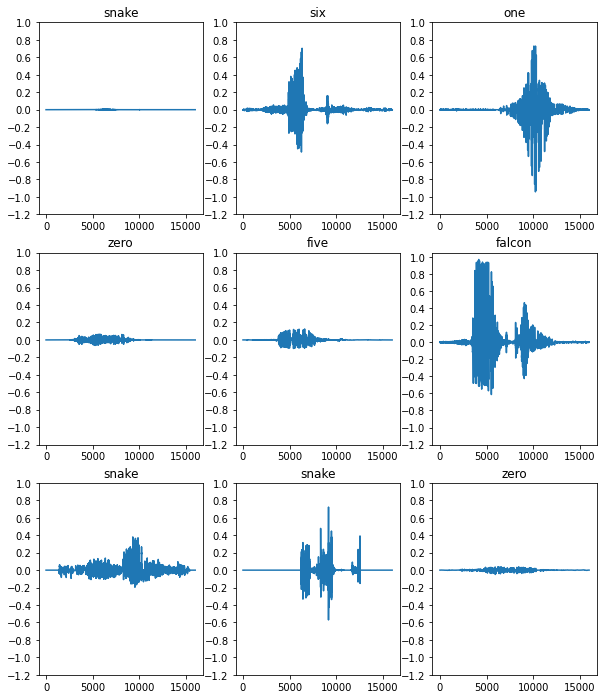

Label: snake
Waveform shape: (16000,)
Spectrogram shape (make this square): (517, 513)
Audio playback


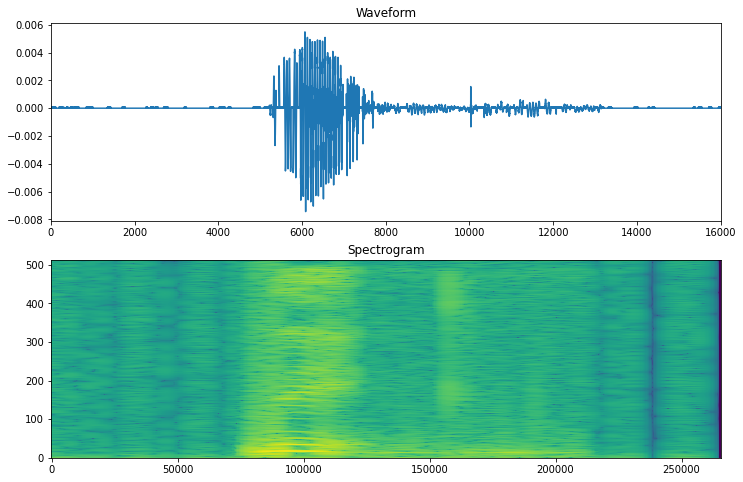

In [3]:
def get_waveform_and_label(file_path):
    audio, _ = tf.audio.decode_wav(tf.io.read_file(file_path))
    waveform = tf.squeeze(audio, axis=-1)
    parts = tf.strings.split(file_path, os.path.sep)
    label = parts[-2]
    return waveform, label

train_ds = tf.data.Dataset.from_tensor_slices(train_files)
train_ds = train_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)

def plot_multiple_waveform(ds):
    rows = 3
    cols = 3
    n = rows*cols
    fig, axes = plt.subplots(rows, cols, figsize=(10, 12))
    for i, (audio, label) in enumerate(ds.take(n)):
      r = i // cols
      c = i % cols
      ax = axes[r][c]
      ax.plot(audio.numpy())
      ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
      label = label.numpy().decode('utf-8')
      ax.set_title(label)
    plt.show()

plot_multiple_waveform(train_ds)

def plot_multiple_spectrogram(ds):
    rows = 3
    cols = 3
    n = rows*cols
    fig, axes = plt.subplots(rows, cols, figsize=(10, 10))
    for i, (spectrogram, label_id) in enumerate(ds.take(n)):
      r = i // cols
      c = i % cols
      ax = axes[r][c]
      plot_spectrogram(np.squeeze(spectrogram.numpy()), ax)
      ax.set_title(labels[label_id.numpy()])
      ax.axis('off')
    plt.show()

def get_spectrogram(waveform):
    # Padding for files with less than 16000 samples
    zero_padding = tf.zeros([16000] - tf.shape(waveform), dtype=tf.float32)
    # Concatenate audio with padding so that all audio clips will be of the same length
    waveform = tf.cast(waveform, tf.float32)
    equal_length = tf.concat([waveform, zero_padding], 0)
    # Choose frame_length and frame_step parameters such that the generated spectrogram "image" is almost square.
    spectrogram = tf.signal.stft(equal_length, fft_length=1024, frame_length=1001, frame_step=31, pad_end=True)  # 257, 70 -> 225, 257 || 255, 123 -> 129, 129
    spectrogram = tf.abs(spectrogram)
    return spectrogram

for waveform, label in train_ds.take(1):
    label = label.numpy().decode('utf-8')
    spectrogram = get_spectrogram(waveform)
    print('Label:', label)
    print('Waveform shape:', waveform.shape)
    print('Spectrogram shape (make this square):', spectrogram.shape)
    img_height, img_width = spectrogram.shape
    print('Audio playback')
    display.display(display.Audio(waveform, rate=16000))

def plot_spectrogram(spectrogram, ax):
  log_spec = np.log(spectrogram.T)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec, shading='auto')

fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])
plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()

def get_spectrogram_and_label_id(audio, label):
  spectrogram = get_spectrogram(audio)
  spectrogram = tf.expand_dims(spectrogram, -1)
  spectrogram = tf.image.grayscale_to_rgb(spectrogram)  # RGB if using pretrained network that is trained on RGB images e.g. ImageNet, else can gray scale
  label_id = tf.argmax(label == labels)
  return spectrogram, label_id

def preprocess(file_path):
    waveform = tf.squeeze(tf.cast(tfio.audio.decode_wav(tf.io.read_file(file_path), dtype=tf.int16), tf.float32) / 32768.0, axis=-1)

    # Padding for files with less than 16000 samples
    zero_padding = tf.zeros([sample_rate] - tf.shape(waveform), dtype=tf.float32)

    # Concatenate audio with padding so that all audio clips will be of the same length
    waveform = tf.cast(waveform, tf.float32)
    equal_length = tf.concat([waveform, zero_padding], 0)

    # Choose frame_length and frame_step parameters such that the generated spectrogram "image" is almost square.
    spectrogram = tfio.audio.spectrogram(equal_length, nfft=1024, window=1001, stride=31)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, -1)
    spectrogram = tf.squeeze(tf.stack([spectrogram, spectrogram, spectrogram], axis=-1))  # 3 channel

    # get label_id
    label = tf.strings.split(file_path, os.path.sep)[-2]
    label_id = tf.argmax(label == labels)

    spectrogram.set_shape([517, 513, 3])
    label_id.set_shape([])
    return spectrogram, label_id

def preprocess_dataset(files):
  return tf.data.Dataset.from_tensor_slices(files).map(preprocess, num_parallel_calls=AUTOTUNE)

train_ds = preprocess_dataset(train_files)
val_ds = preprocess_dataset(val_files)
# plot_multiple_spectrogram(train_ds)

In [4]:
# def train_preprocess(file_path):
#     # Read file into AudioIOTensor, need to specify dtype as running it inside a tf.data function without eager execution CHECKED
#     audio_tensor = tf.cast(tf.squeeze(tfio.audio.AudioIOTensor(file_path, dtype=tf.int16).to_tensor()), tf.float32) / 32768.0
#     #
#     # # Trim noise (TODO: try with different gate, default 0.1)
#     # position = tfio.audio.trim(audio_tensor, axis=0, epsilon=0.2)  # epsilon = noise gate (how loud between 0 to 1)
#     # trimmed_audio_tensor = audio_tensor[position[0]:position[1]]
#     #
#     # # Fade in fade out (TODO: to try)
#     # faded_audio_tensor = tfio.audio.fade(trimmed_audio_tensor, fade_in=1000, fade_out=1000, mode="logarithmic")
#
#     # zero pad to 16000  CHECKED
#     zero_padding = tf.zeros([sample_rate] - tf.shape(audio_tensor), dtype=tf.float32)
#     audio_tensor = tf.cast(audio_tensor, tf.float32)
#     padded_audio_tensor = tf.concat([audio_tensor, zero_padding], 0)
#
#     # spectrogram CHECKED
#     spectrogram = tfio.audio.spectrogram(padded_audio_tensor, nfft=1024, window=1001, stride=31)
#     spectrogram = tf.abs(spectrogram)
#     spectrogram = tf.expand_dims(spectrogram, -1)
#     spectrogram = tf.squeeze(tf.stack([spectrogram, spectrogram, spectrogram], axis=-1))  # 3 channel
#
#     # # Convert to mel-spectrogram
#     # mel_spectrogram = tfio.audio.melscale(spectrogram, rate=sample_rate, mels=250, fmin=20, fmax=8000)
#     #
#     # # Convert to db scale mel-spectrogram (TODO: to try)
#     # dbscale_mel_spectrogram = tfio.audio.dbscale(mel_spectrogram, top_db=80)
#     #
#     # # Convert to log-mel spectrogram
#     # log_mel_spectrogram = tf.math.log(mel_spectrogram + 1e-6)
#     #
#     # # Freq masking
#     # freq_mask = tfio.audio.freq_mask(dbscale_mel_spectrogram, param=10)
#     #
#     # # Time masking
#     # time_mask = tfio.audio.time_mask(freq_mask, param=6)
#     #
#     # # MFCC
#     # mfccs = tf.signal.mfccs_from_log_mel_spectrograms(time_mask)
#
#     # label id extraction
#     label = tf.strings.split(file_path, os.path.sep)[-2]
#     label_id = tf.argmax(label == labels)
#     # log_mel_spectrogram.set_shape([224, 224, 3])
#     # label_id.set_shape([])
#     # spectrogram = tf.signal.stft(audio_tensor, fft_length=1024, frame_length=1001, frame_step=31, pad_end=True)
#     # spectrogram = tf.abs(spectrogram)
#     # log_mel_spectrogram = tf.squeeze(tf.stack([spectrogram, spectrogram, spectrogram], axis=-1))
#     # log_mel_spectrogram.set_shape([517, 513, 3])
#     spectrogram.set_shape([517, 513, 3])
#     return spectrogram, label_id  # Switch output here, log, dbscale, freq mask, time mask, mfccs
#
# def val_preprocess(file_path):
#     # Read file into AudioIOTensor, need to specify dtype as running it inside a tf.data function without eager execution CHECKED
#     audio_tensor = tf.cast(tf.squeeze(tfio.audio.AudioIOTensor(file_path, dtype=tf.int16).to_tensor()), tf.float32) / 32768.0
#
#     # # Trim noise (TODO: try with different gate, default 0.1)
#     # position = tfio.audio.trim(audio_tensor, axis=0, epsilon=0.2)  # epsilon = noise gate (how loud between 0 to 1)
#     # trimmed_audio_tensor = audio_tensor[position[0]:position[1]]
#     # faded_audio_tensor = tfio.audio.fade(trimmed_audio_tensor, fade_in=1000, fade_out=1000, mode="logarithmic")
#
#     # zero pad to 16000  CHECKED
#     zero_padding = tf.zeros([sample_rate] - tf.shape(audio_tensor), dtype=tf.float32)
#     audio_tensor = tf.cast(audio_tensor, tf.float32)
#     padded_audio_tensor = tf.concat([audio_tensor, zero_padding], 0)
#
#     # spectrogram CHECKED
#     spectrogram = tfio.audio.spectrogram(padded_audio_tensor, nfft=1024, window=1001, stride=31)
#     spectrogram = tf.abs(spectrogram)
#     spectrogram = tf.expand_dims(spectrogram, -1)
#     spectrogram = tf.squeeze(tf.stack([spectrogram, spectrogram, spectrogram], axis=-1))  # 3 channel
#
#     # # Convert to mel-spectrogram
#     # mel_spectrogram = tfio.audio.melscale(spectrogram, rate=sample_rate, mels=250, fmin=20, fmax=8000)
#     #
#     # # Convert to db scale mel-spectrogram (TODO: to try)
#     # dbscale_mel_spectrogram = tfio.audio.dbscale(mel_spectrogram, top_db=80)
#     #
#     # # Convert to log-mel spectrogram
#     # log_mel_spectrogram = tf.math.log(mel_spectrogram + 1e-6)
#
#     # label id extraction
#     label = tf.strings.split(file_path, os.path.sep)[-2]
#     label_id = tf.argmax(label == labels)
#     # spectrogram = tf.signal.stft(audio_tensor, fft_length=1024, frame_length=1001, frame_step=31, pad_end=True)
#     # spectrogram = tf.abs(spectrogram)
#     # log_mel_spectrogram = tf.squeeze(tf.stack([spectrogram, spectrogram, spectrogram], axis=-1))
#     # log_mel_spectrogram.set_shape([517, 513, 3])
#     spectrogram.set_shape([517, 513, 3])
#     return spectrogram, label_id  # switch output here to db or log
#
# def test_preprocess(file_path):
#     # Read file into AudioIOTensor, need to specify dtype as running it inside a tf.data function without eager execution CHECKED
#     audio_tensor = tf.cast(tf.squeeze(tfio.audio.AudioIOTensor(file_path, dtype=tf.int16).to_tensor()), tf.float32) / 32768.0
#
#     # # Trim noise (TODO: try with different gate, default 0.1)
#     # position = tfio.audio.trim(audio_tensor, axis=0, epsilon=0.2)  # epsilon = noise gate (how loud between 0 to 1)
#     # trimmed_audio_tensor = audio_tensor[position[0]:position[1]]
#     # faded_audio_tensor = tfio.audio.fade(trimmed_audio_tensor, fade_in=1000, fade_out=1000, mode="logarithmic")
#
#     # zero pad to 16000  CHECKED
#     zero_padding = tf.zeros([sample_rate] - tf.shape(audio_tensor), dtype=tf.float32)
#     audio_tensor = tf.cast(audio_tensor, tf.float32)
#     padded_audio_tensor = tf.concat([audio_tensor, zero_padding], 0)
#
#     # spectrogram CHECKED
#     spectrogram = tfio.audio.spectrogram(padded_audio_tensor, nfft=1024, window=1001, stride=31)
#     spectrogram = tf.abs(spectrogram)
#     spectrogram = tf.expand_dims(spectrogram, -1)
#     spectrogram = tf.squeeze(tf.stack([spectrogram, spectrogram, spectrogram], axis=-1))  # 3 channel
#     #
#     # # Convert to mel-spectrogram
#     # mel_spectrogram = tfio.audio.melscale(spectrogram, rate=sample_rate, mels=250, fmin=20, fmax=8000)
#     #
#     # # Convert to db scale mel-spectrogram (TODO: to try)
#     # dbscale_mel_spectrogram = tfio.audio.dbscale(mel_spectrogram, top_db=80)
#     #
#     # # Convert to log-mel spectrogram
#     # log_mel_spectrogram = tf.math.log(mel_spectrogram + 1e-6)
#     # spectrogram = tf.signal.stft(audio_tensor, fft_length=1024, frame_length=1001, frame_step=31, pad_end=True)
#     # spectrogram = tf.abs(spectrogram)
#     # log_mel_spectrogram = tf.squeeze(tf.stack([spectrogram, spectrogram, spectrogram], axis=-1))
#     # log_mel_spectrogram.set_shape([517, 513, 3])
#     spectrogram.set_shape([517, 513, 3])
#     return spectrogram # switch output here to db or log

In [5]:
# train_ds = tf.data.Dataset.from_tensor_slices(train_files).map(train_preprocess, num_parallel_calls=AUTOTUNE)
# val_ds = tf.data.Dataset.from_tensor_slices(val_files).map(val_preprocess, num_parallel_calls=AUTOTUNE)
# test_ds = tf.data.Dataset.from_tensor_slices(test_files).map(test_preprocess, num_parallel_calls=AUTOTUNE)

for spectrogram, label in train_ds.take(1):
    input_shape = spectrogram.shape

# Training
batch_size = 16
train_ds = train_ds.batch(batch_size).cache().prefetch(AUTOTUNE)
val_ds = val_ds.batch(batch_size).cache().prefetch(AUTOTUNE)

print('Input shape:', input_shape)
norm_layer = Normalization()
norm_layer.adapt(train_ds.map(lambda x, _: x))

# DenseNet201 pretrained
xInput = Input(input_shape, dtype=tf.uint8)
x = Resizing(224, 224)(xInput)
x = norm_layer(x)
x = tf.cast(x, tf.float32)
densenet201 = keras.applications.DenseNet201(include_top=False, weights='imagenet')
densenet201.trainable = True
x = densenet201(x)
x = Flatten()(x)
x = Dropout(0.5)(x)
x = Dense(512)(x)
x = BatchNormalization(epsilon=1.001e-5)(x)
x = Activation('relu')(x)
x = Dropout(0.5)(x)
x = Dense(256)(x)
x = BatchNormalization(epsilon=1.001e-5)(x)
x = Activation('relu')(x)
x = Dropout(0.5)(x)
x = Dense(128)(x)
x = BatchNormalization(epsilon=1.001e-5)(x)
x = Activation('relu')(x)
xOutput = Dense(num_labels)(x)  # no activation as loss using logit=True
model = tf.keras.models.Model(xInput, xOutput)

# xInput = Input(input_shape)
# x = Resizing(64, 64)(xInput)
# x = norm_layer(x)
# x = Conv2D(64, 3)(x)
# x = BatchNormalization(epsilon=1.001e-5)(x)
# x = Activation('relu')(x)
# x = Conv2D(128, 3)(x)
# x = BatchNormalization(epsilon=1.001e-5)(x)
# x = Activation('relu')(x)
# x = Conv2D(256, 3)(x)
# x = BatchNormalization(epsilon=1.001e-5)(x)
# x = Activation('relu')(x)
# x = MaxPooling2D()(x)
# x = Dropout(0.5)(x)
# x = Flatten()(x)
# x = Dense(512, activation='relu')(x)
# x = Dropout(0.5)(x)
# xOutput = Dense(num_labels)(x)  # no activation as using logits for loss
# model = Model(xInput, xOutput)

Input shape: (517, 513, 3)


In [6]:
# TF Hub
# model_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"
# module = hub.KerasLayer(model_url)
#
# class MyBiTModel(tf.keras.Model):
#   def __init__(self, num_classes, module):
#     super().__init__()
#
#     self.num_classes = num_classes
#     self.head = Dense(num_classes, kernel_initializer='zeros')
#     self.bit_model = module
#
#   def call(self, images):
#     # No need to cut head off since we are using feature extractor model
#     bit_embedding = self.bit_model(images)
#     return self.head(bit_embedding)
#
# model = MyBiTModel(num_classes=num_labels, module=module)

In [7]:
# ensemble model
# loaded_models = []
# models_to_load = ['best models/ensemble/89.54 densenet201', 'best models/ensemble/90.00 densenet201', 'best models/ensemble/88.62 densenet201', 'best models/ensemble/87.38 densenet201']
# for i in range (len(models_to_load)):  # loading all models
#     loaded_models.append(models.load_model(models_to_load[i]))
#     print(f'Loaded {models_to_load[i]}')

In [8]:
# for i in range(len(loaded_models)):
#     model = loaded_models[i]
#     model._name = f'ensemble_model_{i}'
#     for layer in model.layers:
#         layer.trainable = False  # freeze model
#         layer._name = f'ensemble_{str(i)}_{layer.name}'
#
# ensemble_input = Input([img_height, img_width, 3])
# # ensemble_inputs = [ensemble_input for _ in range(len(loaded_models))]
# ensemble_outputs = [model(ensemble_input) for model in loaded_models]
# # ensemble_outputs = [model.output for model in loaded_models]
# # ensemble_outputs = Activation('softmax')(ensemble_outputs)
# ensemble_outputs = concatenate(ensemble_outputs)
# ensemble_outputs = Dense(32, activation='relu')(ensemble_outputs)
# ensemble_output = Dense(num_labels)(ensemble_outputs)
# ensemble_model = Model(ensemble_input, ensemble_output, name='Ensemble_Model')

In [9]:
opt = keras.optimizers.Adam(learning_rate=1e-3, epsilon=1e-6)
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics = ['accuracy']
epoch = 100
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0, patience=10, verbose=1,
                                     mode='auto', baseline=None, restore_best_weights=True),
    # tf.keras.callbacks.ModelCheckpoint('./best_model',monitor='val_accuracy',save_best_only=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=4, verbose=1)
]
model.compile(optimizer=opt, loss=loss, metrics=metrics)
plot_model(model, show_shapes=True, show_dtype=True, show_layer_names=True, to_file='SC1.png') # SC1_ensemble.png
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 517, 513, 3)]     0         
_________________________________________________________________
resizing (Resizing)          (None, 224, 224, 3)       0         
_________________________________________________________________
normalization (Normalization (None, 224, 224, 3)       7         
_________________________________________________________________
tf.cast (TFOpLambda)         (None, 224, 224, 3)       0         
_________________________________________________________________
densenet201 (Functional)     (None, None, None, 1920)  18321984  
_________________________________________________________________
flatten (Flatten)            (None, 94080)             0         
_________________________________________________________________
dropout (Dropout)            (None, 94080)             0     

In [10]:
history = model.fit(train_ds, epochs=epoch, validation_data=val_ds, callbacks=callbacks, use_multiprocessing=True, verbose=1)
model.save('sc1')
# batch_size = 8
# ens_train_ds = preprocess_dataset(val_files[:round(len(val_files) * 0.7)])
# ens_val_ds = preprocess_dataset(val_files[round(len(val_files) * 0.7):])
# ens_train_ds = ens_train_ds.batch(batch_size).cache().prefetch(AUTOTUNE)
# ens_val_ds = ens_val_ds.batch(batch_size).cache().prefetch(AUTOTUNE)
# history = ensemble_model.fit(ens_train_ds, epochs=epoch, validation_data=ens_val_ds, callbacks=callbacks, use_multiprocessing=True, verbose=1)

Epoch 1/100
163/163 [==============================] - 63s 272ms/step - loss: 2.6103 - accuracy: 0.1342 - val_loss: 11.9803 - val_accuracy: 0.1262

Exception ignored in: <function ScopedTFFunction.__del__ at 0x000001F2FBF40820>
Traceback (most recent call last):
  File "C:\Program Files\Python38\lib\site-packages\tensorflow\python\framework\c_api_util.py", line 110, in __del__
    self.deleter(self.func)
KeyboardInterrupt: 


In [11]:
# batch_size = 2
# train_ds = train_ds.batch(batch_size).cache().prefetch(AUTOTUNE)
# val_ds = val_ds.batch(batch_size).cache().prefetch(AUTOTUNE)
# ensemble_model.evaluate(train_ds)  # model cant save

In [12]:
# Generate prediction csv
# model = models.load_model('sc1')
to_predict_ds = preprocess_dataset(list(map(str, test_files)))  # TODO: replace with test only preprocessing, see sc1v2 end
i = 0
predicted_labels, filenames = [], []
for spectrogram, label in to_predict_ds.batch(1):
    # print(files_to_predict[i])
    # display.display(display.Audio(files_to_predict[i]))
    filenames.append(os.path.basename(test_files[i]))
    prediction =model(spectrogram)
    prediction_value = tf.nn.softmax(prediction[0]).numpy()
    predicted_label = labels[np.argmax(prediction_value)]
    predicted_labels.append(predicted_label)
    # plt.bar(labels, prediction_value)  # need to softmax raw prediction because model does not include softmax
    # plt.title(f'Confidence for each class')
    # plt.show()
    # print(f'True label: {labels[label[0]]}, Predicted label: {labels[np.argmax(prediction_value)]}, confidence level: {round(np.amax(prediction_value) * 100, 5)}%\n')
    i += 1

df = pd.DataFrame(list(zip(filenames, predicted_labels)))
df.to_csv('challenge_2_team_Tensor is not flowing.csv', index=False, header=False)  # tested submission file format passed

KeyboardInterrupt: 

In [ ]:
'''
ResNet 50 Full train with norm layer image net weight final val: 8415
spectrogram = tf.signal.stft(equal_length, frame_length=1001, frame_step=31, pad_end=True)  # 257, 70 -> 225, 257 || 255, 123 -> 129, 129

DenseNet201 Full train without preprocess but with norm. Final val: 8954
spectrogram = tf.signal.stft(equal_length, fft_length=1024, frame_length=1001, frame_step=31, pad_end=True)  # 257, 70 -> 225, 257 || 255, 123 -> 129, 129
same setting run no2: 9000
no 3: 8862
no4: 87.38
final ensemble results:
val last 30%: 9590, train entire: 9719

ResNet 152 V2 Full train with norm layer final val: 7615
BiT m-r101x1 final val: 6019
'''